# This script demonstrates an application of E(3) Equivariant Graph Neural Networks (EGNNs) 
## in processing a 2D cloud of points (nodes) and mapping them to their centroid based on mass. The code combines elements of geometric deep learning and clustering in latent space using a Gaussian Mixture Model (GMM).

In [12]:
from egnn_gmm import train_egnn_gmm, EGNN, get_edges
import torch
from torch import nn
from sklearn.mixture import GaussianMixture
import numpy as np

def generate_data(num_nodes, feature_dim, cutoff=0.1):
    node_features = torch.rand((num_nodes, feature_dim))  # Random node features
    node_coords = torch.rand((num_nodes, 2))  # Random 2D coordinates
    edge_index, _ = get_edges(node_coords, cutoff)  # Generate edges
    return node_features, node_coords, edge_index

def update_coordinates(node_coords, masses, alpha=1.0):
    # Ensure masses is of shape [20, 1] for broadcasting
    masses = masses.squeeze()  # Shape: [20]
    
    # Compute centroid using mass-weighted average of coordinates
    mass_sum = masses.sum()
    centroid = (node_coords.T * masses).T.sum(dim=0) / mass_sum  # Shape: [2]
    
    # Move nodes towards centroid proportionally to their masses
    displacement = alpha * masses[:, None] * (centroid - node_coords)  # Shape: [20, 2]
    
    # Update coordinates
    updated_coords = node_coords + displacement
    
    return updated_coords

# Hyperparameters
num_nodes = 6
feature_dim = 1
hidden_dim =10
output_dim = 1
cutoff = 1.5
device = 'cpu'

# Initialize model
egnn_model = EGNN(
    in_node_nf=feature_dim,
    hidden_nf=hidden_dim,
    out_node_nf=output_dim,
    n_layers=3
).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(egnn_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
gmm = GaussianMixture(n_components=2)
hidden_representations = []
# Training loop
for epoch in range(2000):
    optimizer.zero_grad()
    # Generate dummy data
    node_features, node_coords, edge_index = generate_data(num_nodes, feature_dim, cutoff)
    target_coords = update_coordinates(node_coords,node_features)
    target_features = torch.norm(node_features)

    # Forward pass
    pred_features, pred_coords = egnn_model(node_features, node_coords, edge_index)
    hidden = egnn_model.get_hidden_representation(node_features,node_coords,edge_index)
    hidden_representations.append(hidden.detach().numpy())
    # Loss computation
    feature_loss = loss_fn(pred_features, target_features)
    coord_loss = loss_fn(pred_coords, target_coords)
    loss = coord_loss +0.001*feature_loss

    # Backward pass
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}",feature_loss.item(),"coordloss",coord_loss.item())
hidden_representations = np.vstack(hidden_representations)
gmm.fit(hidden_representations)
print(f"Epoch {epoch}: GMM trained on latent space.")


Epoch 0: Loss = 0.0253 1.358831763267517 coordloss 0.02395239658653736
Epoch 500: Loss = 0.0010 0.20408613979816437 coordloss 0.0007981265080161393
Epoch 1000: Loss = 0.0020 0.019736824557185173 coordloss 0.0019494890002533793
Epoch 1500: Loss = 0.0002 0.05312943086028099 coordloss 0.0001480236678617075
Epoch 1999: GMM trained on latent space.


In [27]:
# Importing necessary libraries
from egnn_gmm import train_egnn_gmm, EGNN, get_edges  # EGNN model and edge generation utility
import torch
from torch import nn
from sklearn.mixture import GaussianMixture  # GMM for clustering
import numpy as np

# Function to generate synthetic 2D point cloud data
def generate_data(num_nodes, feature_dim, cutoff=1.1):
    """
    Generates random node features, 2D coordinates, and edges for a graph.

    Args:
    - num_nodes: Number of nodes in the graph.
    - feature_dim: Dimension of the node features.
    - cutoff: Distance threshold for edge creation.

    Returns:
    - node_features: Random features for each node (shape: [num_nodes, feature_dim]).
    - node_coords: Random 2D coordinates for each node (shape: [num_nodes, 2]).
    - edge_index: Edge indices generated based on the cutoff distance.
    """
    node_features = torch.rand((num_nodes, feature_dim))  # Random node features
    node_coords = torch.rand((num_nodes, 2))  # Random 2D coordinates
    edge_index, _ = get_edges(node_coords, cutoff)  # Generate edges
    return node_features, node_coords, edge_index

# Function to compute mass-weighted centroid and update coordinates
def update_coordinates(node_coords, masses, alpha=1.0):
    """
    Updates node coordinates by moving them towards the centroid proportional to their masses.

    Args:
    - node_coords: 2D coordinates of nodes (shape: [num_nodes, 2]).
    - masses: Mass values for each node (shape: [num_nodes, 1]).
    - alpha: Scaling factor for the displacement.

    Returns:
    - updated_coords: Updated coordinates of nodes (shape: [num_nodes, 2]).
    """
    # Ensure masses is of shape [num_nodes] for broadcasting
    masses = masses.squeeze()  # Shape: [num_nodes]
    
    # Compute the centroid using mass-weighted average of coordinates
    mass_sum = masses.sum()
    centroid = (node_coords.T * masses).T.sum(dim=0) / mass_sum  # Shape: [2]
    
    # Compute displacement towards the centroid, scaled by mass
    displacement = alpha * masses[:, None] * (centroid - node_coords)  # Shape: [num_nodes, 2]
    
    # Update the coordinates
    updated_coords = node_coords + displacement
    
    return updated_coords

# Hyperparameters for the EGNN model and training
num_nodes = 6           # Number of nodes in the graph
feature_dim = 1         # Feature dimension for nodes
hidden_dim = 10         # Dimension of hidden representations
output_dim = 1          # Output feature dimension
cutoff = 1.5            # Edge cutoff distance for graph construction
device = 'cpu'          # Device for computation

# Initialize the EGNN model
egnn_model = EGNN(
    in_node_nf=feature_dim,   # Input node feature dimension
    hidden_nf=hidden_dim,     # Hidden layer feature dimension
    out_node_nf=output_dim,   # Output node feature dimension
    n_layers=3                # Number of EGNN layers
).to(device)
egnn_model.train()

# Optimizer and loss function
optimizer = torch.optim.Adam(egnn_model.parameters(), lr=0.01)  # Adam optimizer
loss_fn = nn.MSELoss()                                          # Mean Squared Error loss
gmm = GaussianMixture(n_components=2)                           # GMM with 2 clusters
# Training loop
hidden_representations = []  # Store latent representations for GMM clustering
for epoch in range(8000):    # Training for 2000 epochs
    optimizer.zero_grad()

    # Generate random data for the current epoch
    node_features, node_coords, edge_index = generate_data(num_nodes, feature_dim, cutoff)
    target_coords = update_coordinates(node_coords, node_features)  # Compute target coordinates
    target_features = torch.norm(node_features)                    # Target feature norm

    # Forward pass through the EGNN model
    pred_features, pred_coords = egnn_model(node_features, node_coords, edge_index)
    hidden = egnn_model.get_hidden_representation(node_features, node_coords, edge_index)  # Extract latent representations
    hidden_representations.append(hidden.detach().numpy())

    # Compute losses for features and coordinates
    feature_loss = loss_fn(pred_features, target_features)  # Loss on predicted features
    coord_loss = loss_fn(pred_coords, target_coords)        # Loss on predicted coordinates
    loss = coord_loss + 0.001 * feature_loss                # Combined loss

    # Backward pass and optimization step
    loss.backward()
    optimizer.step()
    
    # Log progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Feature Loss = {feature_loss.item():.4f}, Coord Loss = {coord_loss.item():.4f}")

# Fit GMM to the latent space after training
hidden_representations = np.vstack(hidden_representations)  # Stack all hidden representations
gmm.fit(hidden_representations)                            # Fit the GMM
print(f"Epoch {epoch}: GMM trained on latent space.")


C:\Users\cuau_\miniconda3\envs\cuauenv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Loss = 0.0509, Feature Loss = 3.5520, Coord Loss = 0.0473
Epoch 500: Loss = 0.0018, Feature Loss = 0.0838, Coord Loss = 0.0017
Epoch 1000: Loss = 0.0006, Feature Loss = 0.0429, Coord Loss = 0.0006
Epoch 1500: Loss = 0.0008, Feature Loss = 0.2817, Coord Loss = 0.0006
Epoch 2000: Loss = 0.0005, Feature Loss = 0.0128, Coord Loss = 0.0005
Epoch 2500: Loss = 0.0001, Feature Loss = 0.0018, Coord Loss = 0.0001
Epoch 3000: Loss = 0.0001, Feature Loss = 0.0019, Coord Loss = 0.0001
Epoch 3500: Loss = 0.0002, Feature Loss = 0.0154, Coord Loss = 0.0002
Epoch 4000: Loss = 0.0001, Feature Loss = 0.0039, Coord Loss = 0.0001
Epoch 4500: Loss = 0.0000, Feature Loss = 0.0001, Coord Loss = 0.0000
Epoch 5000: Loss = 0.0000, Feature Loss = 0.0012, Coord Loss = 0.0000
Epoch 5500: Loss = 0.0001, Feature Loss = 0.0056, Coord Loss = 0.0001
Epoch 6000: Loss = 0.0002, Feature Loss = 0.0087, Coord Loss = 0.0002
Epoch 6500: Loss = 0.0000, Feature Loss = 0.0025, Coord Loss = 0.0000
Epoch 7000: Loss = 0.000

# Objective: This code evaluates an EGNN model on 209 test examples and selectively visualizes results where:

The test samples are far from the training set, determined by high negative log-likelihood (NLL mean > 0.4) based on the Gaussian Mixture Model (GMM) trained on the latent space.
The model generalized well, indicated by a low prediction error (error < 0.03).
 Latent Space Analysis with GMM: The negative log-likelihood (nll) measures how well the test examples fit the GMM, with high NLL indicating outliers relative to the training distribution.

 Visualization: Only examples that satisfy the above conditions are plotted, showing the predicted coordinates (in red) against the target coordinates (in brown). This approach highlights cases where the model performs well on challenging examples.

 Applications: This process is useful for analyzing model performance on out-of-distribution examples, detecting generalization capability, and validating robustness in scenarios involving novel data.

-0.4519469646229669 0.01161515899002552
1.5611191399257387 0.02944537252187729


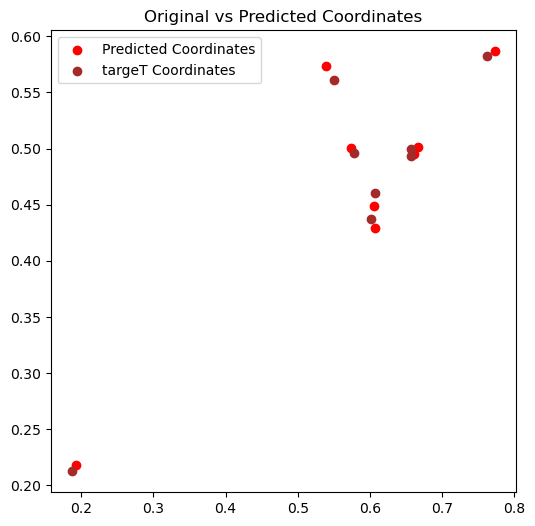

-0.11377907586834296 0.026540813967585564
-0.3979837850941179 0.036184243857860565
-0.3681549765340482 0.022372422739863396
-0.38707156096613293 0.037492718547582626
-0.46186698649050023 0.022636862471699715
-0.4095085448733643 0.02012975513935089
0.05764721490361746 0.02462497353553772
-0.4541977519359281 0.021053530275821686
-0.40734205914683497 0.028622308745980263
-0.4100110642854723 0.03263159841299057
0.044179813601355575 0.011718155816197395
0.8088806554960253 0.03892039507627487
0.19937826404881537 0.07942482829093933
-0.3486776456333278 0.021141337230801582
-0.3708509192864707 0.016455553472042084
-0.41978680941344526 0.024210266768932343
1.5694520769887976 0.015748489648103714


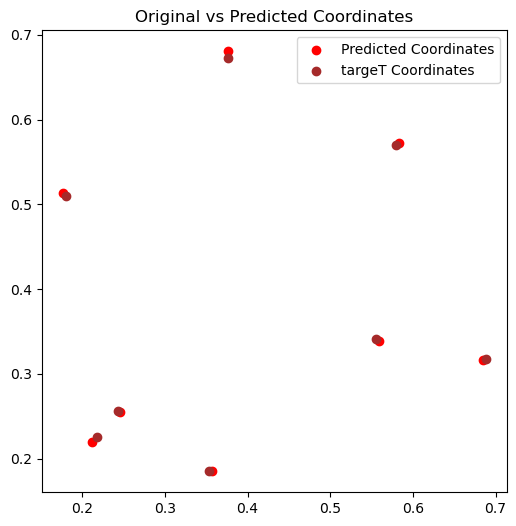

-0.45417919433996645 0.0321957990527153
0.4954883755746973 0.03392958268523216
-0.41172437782990395 0.027307264506816864
-0.22296130885891113 0.03778424113988876
-0.2909270293875578 0.027210475876927376
-0.4335926874398191 0.029550826177001
-0.34843610082916926 0.026451077312231064
-0.3265771668409404 0.0175849087536335
-0.24710088032814848 0.03100723959505558
-0.45053838781594024 0.020670214667916298
-0.4576356620616963 0.031252969056367874
-0.37010134360156566 0.0271168015897274
-0.24664733699787647 0.019685856997966766
-0.45027061551992287 0.009542195126414299
-0.32376629602727863 0.01636740006506443
-0.31155273336019096 0.032915301620960236
-0.38490358746195763 0.021814269945025444
0.4162045475416931 0.039666734635829926
-0.024626536703049894 0.02307894080877304
-0.4072357344534675 0.02497677318751812
-0.39529967663031806 0.01814248226583004
-0.3901827639149803 0.030909676104784012
-0.34963014950725435 0.019886348396539688
-0.3533122098496069 0.0143493777140975
-0.3379622746210368 

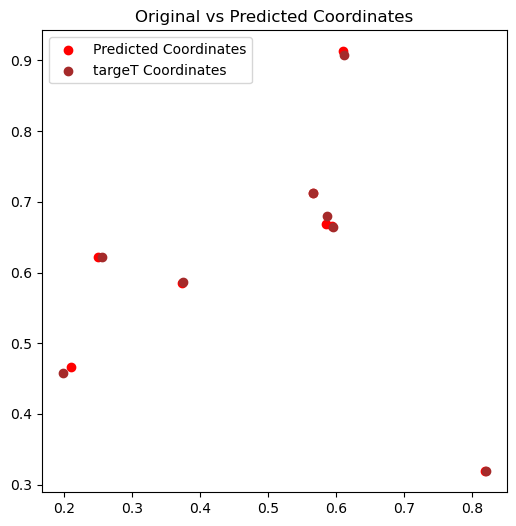

-0.2906213131186542 0.022543858736753464
-0.27569561631077577 0.018634935840964317
-0.12194372446459348 0.02718430757522583
0.35328002485070975 0.045473504811525345
-0.46428814162955434 0.012694570235908031
0.7618740246889278 0.018213797360658646


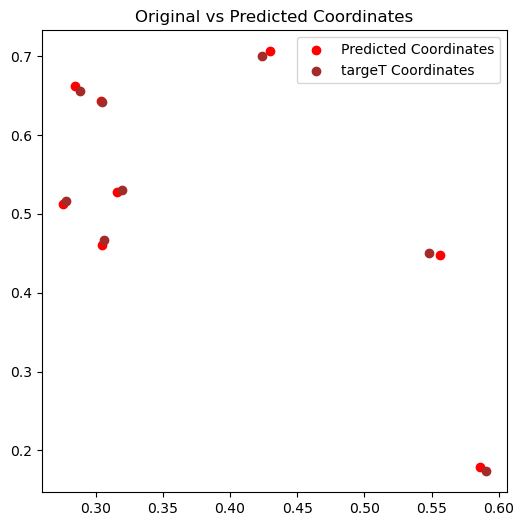

-0.11821229324696741 0.017698703333735466
0.4986917260887236 0.014964519068598747


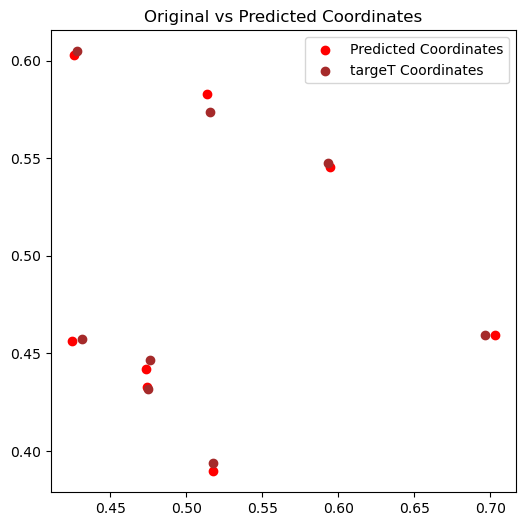

-0.2678295996794172 0.04093630239367485
0.5184122881657889 0.029707619920372963


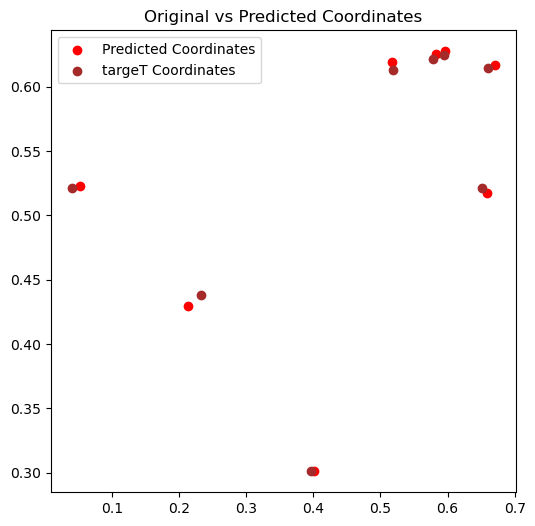

-0.4535222734182769 0.021235359832644463
-0.3306847346227307 0.022763390094041824
-0.45462889753286306 0.036000657826662064
-0.4328651757235384 0.019164131954312325
-0.45144328442037784 0.018840420991182327
-0.36665584511321314 0.040601663291454315
-0.06005495269681296 0.03635649383068085
-0.39634648124838057 0.03325943276286125
-0.4482584730492028 0.014978714287281036
-0.3455971048601952 0.03858174756169319
0.6127279075386779 0.05822009965777397
0.46480234650380436 0.04842628166079521
-0.46624954704490107 0.028739003464579582
0.21239206113236153 0.03370501846075058
-0.35580479647801955 0.025701012462377548
-0.18452647754470666 0.037532225251197815
-0.2309560394891692 0.033682115375995636
0.1967166171961959 0.040953513234853745
-0.07454223735294974 0.015722768381237984
-0.4636058196796624 0.01950090192258358
-0.3751825039106485 0.021584121510386467
-0.41645637162133803 0.01346602849662304
-0.19310134220847308 0.030046673491597176
-0.04795799220703527 0.012412403710186481
-0.39230066985

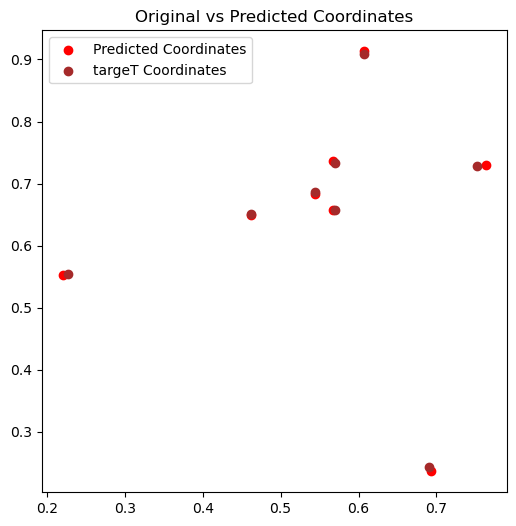

0.6813497734085299 0.013865917921066284


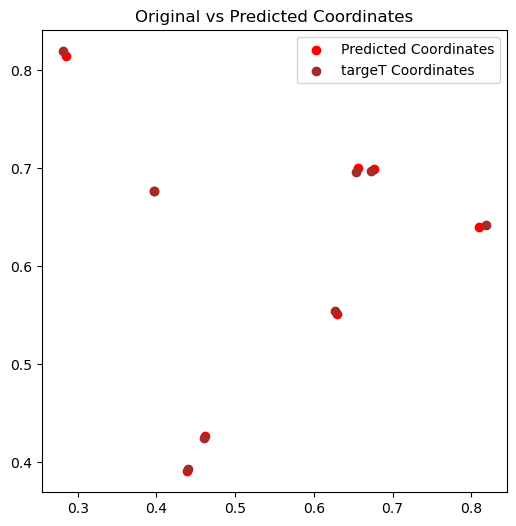

-0.45977589111149897 0.016694415360689163
0.1723467561058843 0.03265529125928879
0.35708669972970847 0.05967298150062561
-0.44305730723174125 0.05216294154524803
-0.4503917437932917 0.017396477982401848
-0.46151343160135805 0.0282534658908844
0.5020962876983635 0.03099890798330307
-0.1589070993985112 0.03888533636927605
0.04091822057798239 0.0206296443939209
-0.4198186131374043 0.021717147901654243
0.4858666278901703 0.024295227602124214


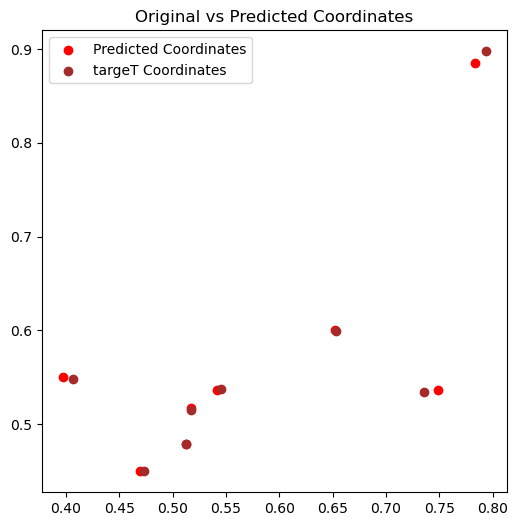

2.7806315124982213 0.03974924236536026
0.008187776966228688 0.027027534320950508
-0.30156401263416943 0.05096334218978882
-0.45256931513692683 0.020732583478093147
-0.27869690197001973 0.01766263134777546
0.2089759653805845 0.010141097009181976
1.8074496260383914 0.057747531682252884
-0.3804464386491203 0.06157572939991951
0.466890024485065 0.04579372704029083
0.03258954310083209 0.02161196619272232
1.754446034032327 0.04763912782073021
-0.4292257289232445 0.029147785156965256
-0.4266083240553623 0.020795797929167747
1.3688204103648984 0.05649116262793541
-0.2775004250888433 0.02082616649568081
-0.21004491191615685 0.05895378068089485
-0.444193056491924 0.012990832328796387
0.40718615517528856 0.049938395619392395
-0.36807121414126304 0.04230893775820732
-0.348343292342849 0.05025395750999451
-0.3376246331799523 0.018117353320121765
-0.16974886079142892 0.051028214395046234
-0.38833079560096606 0.02661856636404991
-0.44253266235980515 0.037066783756017685
-0.20823316809928866 0.0408344

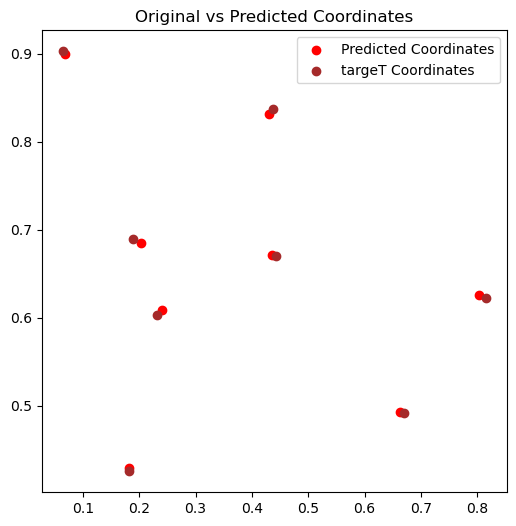

-0.06651448545916061 0.06265996396541595
-0.46388147184966766 0.012932376936078072
-0.4509588306092844 0.017427826300263405
-0.14526202226672372 0.016521574929356575
0.8966518820838552 0.022739360108971596


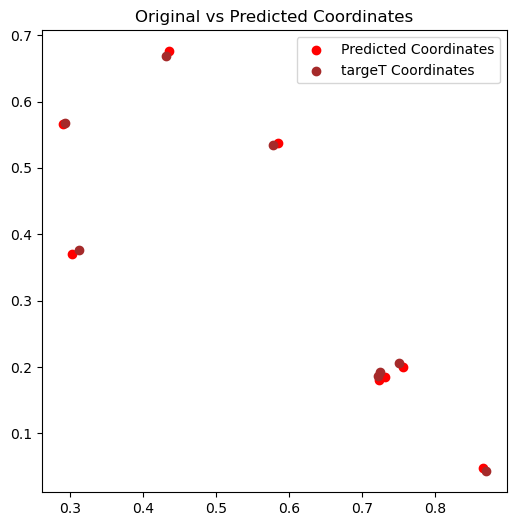

-0.026617942830014216 0.03811319172382355
-0.12636784256175873 0.02515381947159767
-0.41116036595256855 0.040601328015327454
-0.43381121632441766 0.0366765521466732
1.0034292007464019 0.027238082140684128


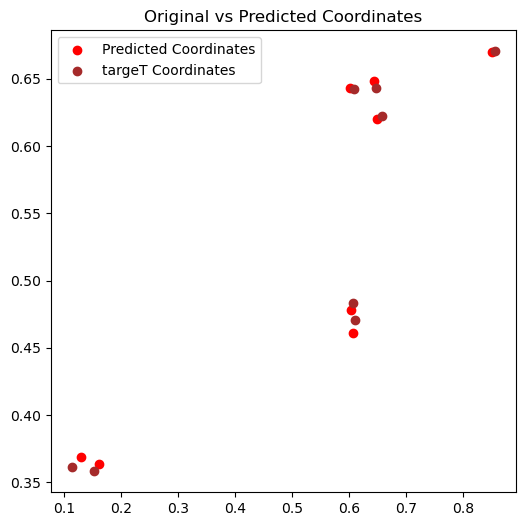

1.8603246469082333 0.05585918575525284
1.8985355823708414 0.011760846711695194


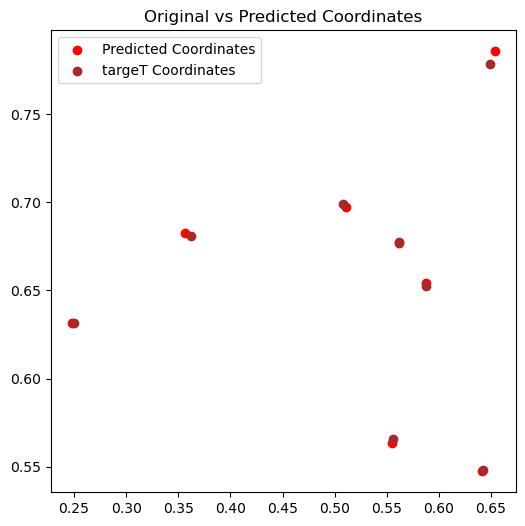

0.788382948619188 0.018943294882774353


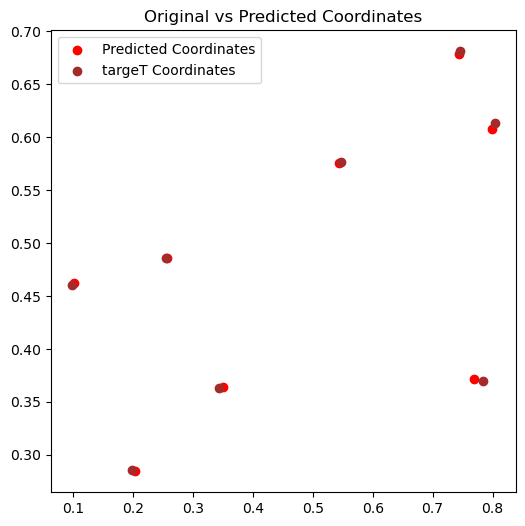

0.15625369515812565 0.048012349754571915
-0.4229542722525773 0.03379514813423157
1.0788840512978788 0.04662785679101944
-0.0999041587205283 0.017404671758413315
-0.25829581716335065 0.024487830698490143
-0.3046515037715832 0.03208160400390625
-0.10188446523306348 0.017792019993066788
-0.28299550611897184 0.02456085942685604
0.04212982541490384 0.03286612778902054
0.43405920853978214 0.03480713441967964
-0.3031885424976251 0.01607160083949566
-0.43534737769843934 0.030123893171548843
-0.43536112624618184 0.019756751134991646
-0.45053676387414404 0.0604705847799778
1.17822916127713 0.03287272900342941
0.6752090607801864 0.043652743101119995
-0.0034746830497763143 0.07443466782569885
-0.07941573988081796 0.03446769714355469
2.8153378591467746 0.018704792484641075


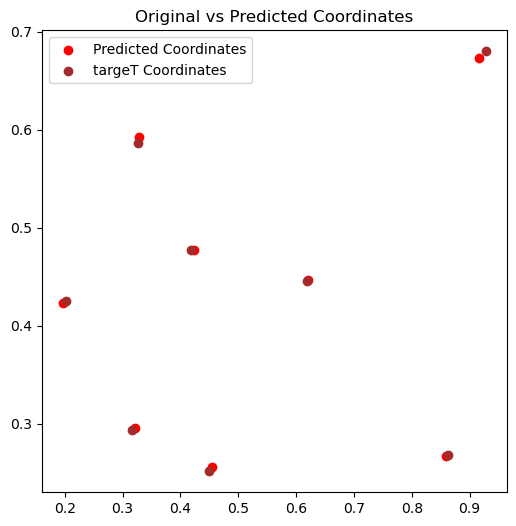

-0.33057383933586404 0.023563707247376442
-0.4022390122593973 0.018737806007266045
0.08175885361491068 0.029657704755663872
-0.46384109042929195 0.02432628720998764
-0.3505865637421415 0.033810969442129135
-0.2844749676264464 0.024460338056087494
0.2592586810924695 0.033037714660167694
0.427747890713007 0.02521545998752117


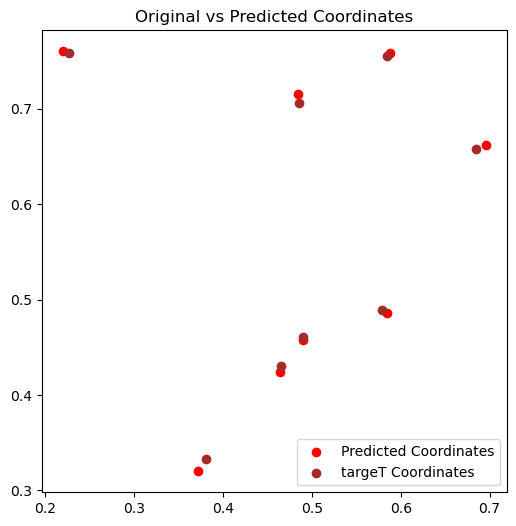

-0.37244403996773096 0.026802048087120056
-0.38703125080130213 0.03229951485991478
0.03936083914474931 0.013499352149665356


In [29]:
import matplotlib.pyplot as plt

for k in range(209):
    node_features, node_coords, edge_index = generate_data(8, 1, cutoff)
    target_coords = update_coordinates(node_coords,node_features)
    hidden_features = egnn_model.get_hidden_representation(node_features,node_coords,edge_index)
    nll = -gmm.score_samples(hidden_features.detach().numpy())
    pred_features, pred_coords = egnn_model(node_features, node_coords, edge_index)
    error=torch.norm(target_coords-pred_coords).item()
    print(nll.mean(),error)
    pred_coords=pred_coords.detach().numpy() 
    if nll.mean()>0.4 and error<0.03:
        # Visualize coordinates before and after training
        plt.figure(figsize=(6, 6))
        # plt.scatter(node_coords[:, 0], node_coords[:, 1], color='blue', label='Original Coordinates')
        plt.scatter(pred_coords[:, 0], pred_coords[:, 1], color='red', label='Predicted Coordinates')
        plt.scatter(target_coords[:, 0], target_coords[:, 1], color='brown', label='targeT Coordinates')
        # plt.scatter(dif[:, 0], dif[:, 1], color='yellow', label='diff')
        plt.legend()
        plt.title("Original vs Predicted Coordinates")
        plt.show()

-0.41913328064571376 0.03027747943997383
-0.4013696311371419 0.025872107595205307
-0.06406326050149355 0.02006101980805397
0.5709315506072548 0.026416797190904617
-0.014138410897902645 0.031229084357619286
-0.34275000251477356 0.02174680121243
-0.4446094281973022 0.012556931003928185
-0.22204246691653656 0.03960736095905304
-0.18856071828816423 0.009424202144145966
-0.12576532149173272 0.030840376392006874
-0.01091646943081278 0.016743002459406853
-0.4139945861000926 0.018381614238023758
0.142880131097364 0.03963211923837662
0.30427838075959646 0.03059535287320614
-0.44431460213364654 0.029142674058675766
0.2766180841479918 0.061865296214818954
0.09819675371719741 0.05007173493504524
1.0679371806942792 0.0307148490101099
-0.18631920358576262 0.058414652943611145
-0.4338155826344834 0.017262060195207596
-0.4529459495550011 0.025011083111166954
-0.13978131519272258 0.026852093636989594
0.05942868796510333 0.030771348625421524
-0.29465136286902016 0.026560992002487183
-0.39921304721452056

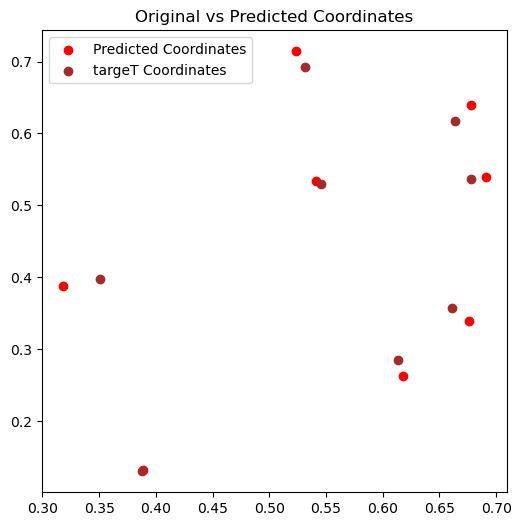

-0.3399504840941948 0.02041505090892315
-0.37594266769085316 0.022154277190566063
-0.17236750949979388 0.027218671515583992
-0.43090677441858594 0.03096158057451248
-0.3220321177884116 0.04769232124090195
-0.2755562064065328 0.014630435034632683
-0.22927937308366073 0.022765755653381348
-0.3614502267591143 0.03206761181354523
-0.4418295103190266 0.01551339216530323
0.18765915215895312 0.031925350427627563
-0.2679908061443467 0.026203032582998276
-0.4533270607827164 0.029936371371150017
0.38513170599612384 0.027185961604118347
-0.45954879624819994 0.02528231032192707
-0.416850421495731 0.032646238803863525
0.11708292773220907 0.03700653836131096
-0.06378282208576623 0.03822306543588638
-0.092358922903725 0.021348396316170692
0.29952660102118084 0.031030327081680298
1.4031930991808301 0.02185661345720291
0.19752742496815406 0.023173868656158447
-0.05092406823585049 0.05198393389582634
1.2928096099411324 0.0489625409245491
4.014892560658497 0.025527548044919968
1.6759036031388774 0.028371

In [34]:
import matplotlib.pyplot as plt
#the other way around, input data that seemed good and results were terrible
for k in range(209):
    node_features, node_coords, edge_index = generate_data(8, 1, cutoff)
    target_coords = update_coordinates(node_coords,node_features)
    hidden_features = egnn_model.get_hidden_representation(node_features,node_coords,edge_index)
    nll = -gmm.score_samples(hidden_features.detach().numpy())
    pred_features, pred_coords = egnn_model(node_features, node_coords, edge_index)
    error=torch.norm(target_coords-pred_coords).item()
    print(nll.mean(),error)
    pred_coords=pred_coords.detach().numpy() 
    if nll.mean()<-0.1 and error>0.06:
        # Visualize coordinates before and after training
        plt.figure(figsize=(6, 6))
        # plt.scatter(node_coords[:, 0], node_coords[:, 1], color='blue', label='Original Coordinates')
        plt.scatter(pred_coords[:, 0], pred_coords[:, 1], color='red', label='Predicted Coordinates')
        plt.scatter(target_coords[:, 0], target_coords[:, 1], color='brown', label='targeT Coordinates')
        # plt.scatter(dif[:, 0], dif[:, 1], color='yellow', label='diff')
        plt.legend()
        plt.title("Original vs Predicted Coordinates")
        plt.show()